# Importing libs

In [1]:
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

from dataset import get_cifar_train_loader, get_cifar_valid_loader

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

# Loading and normalizing data

In [4]:
batch_size = 32

train_loader = get_cifar_train_loader(batch_size)
valid_loader = get_cifar_valid_loader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from resnet import Encoder, BasicBlock, Decoder, Autoencoder, ResNet18
from torchsummary import summary

encoder = Encoder(BasicBlock).to(device)
decoder = Decoder().to(device)
autoencoder = Autoencoder(encoder, decoder)
summary(autoencoder, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
       BatchNorm2d-2            [-1, 8, 32, 32]              16
            Conv2d-3            [-1, 8, 32, 32]             576
       BatchNorm2d-4            [-1, 8, 32, 32]              16
            Conv2d-5            [-1, 8, 32, 32]             576
       BatchNorm2d-6            [-1, 8, 32, 32]              16
        BasicBlock-7            [-1, 8, 32, 32]               0
            Conv2d-8            [-1, 8, 32, 32]             576
       BatchNorm2d-9            [-1, 8, 32, 32]              16
           Conv2d-10            [-1, 8, 32, 32]             576
      BatchNorm2d-11            [-1, 8, 32, 32]              16
       BasicBlock-12            [-1, 8, 32, 32]               0
           Conv2d-13           [-1, 16, 16, 16]           1,152
      BatchNorm2d-14           [-1, 16,

In [6]:
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=0.0005)
loss_fcn = nn.MSELoss()

In [7]:
num_epochs = 20
min_valid_loss = float("+Inf")

for epoch_ind in range(num_epochs):
    print(f"Epoch {epoch_ind}")
    
    autoencoder.train()
    for images, _ in train_loader:
        images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_fcn(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    autoencoder.eval()
    valid_loss = 0
    
    for images, _ in valid_loader:
        images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_fcn(outputs, images)
        valid_loss += loss.item()
    
    valid_loss = valid_loss / len(valid_loader)
    
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(encoder, "best_encoder.pt")
        print("New best")
    
    print(valid_loss)
        

Epoch 0
New best
0.14421267309984842
Epoch 1
New best
0.11105748596854104
Epoch 2
New best
0.10756424117012146
Epoch 3
New best
0.10154310959025313
Epoch 4
New best
0.0867299347068555
Epoch 5
New best
0.0700124340435377
Epoch 6
New best
0.06508293158758563
Epoch 7
New best
0.06010762358102174
Epoch 8
New best
0.05241167631012182
Epoch 9
New best
0.05003295265161953
Epoch 10
New best
0.04807794873659222
Epoch 11
New best
0.04231953758377427
Epoch 12
New best
0.038985386187323744
Epoch 13
New best
0.03868734574736878
Epoch 14
0.03886485939470533
Epoch 15
New best
0.03583909988927003
Epoch 16
0.03736096219466136
Epoch 17
New best
0.033316664046610885
Epoch 18
0.03445320984068961
Epoch 19
0.033439090695624916


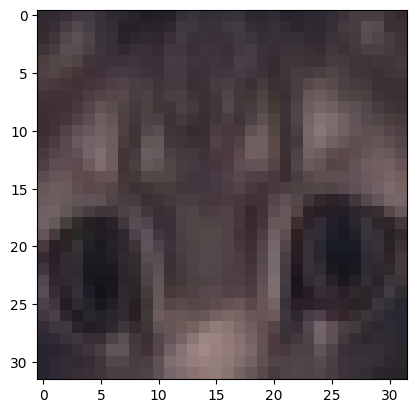

In [8]:
img = next(iter(valid_loader))[0][1:2].to(device)
pred_img = autoencoder(img)

plt.imshow(np.transpose(img[0].cpu() / 5 + 0.5, (1, 2, 0)))

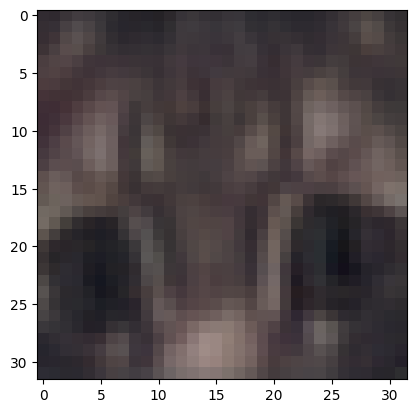

In [9]:
plt.imshow(np.transpose(pred_img[0].cpu().detach() / 5 + 0.5, (1, 2, 0)))